In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from enum import Enum

Let's start by gathering all the data from the various implementations. Below is a (hardcoded) list of all the implementations as well as the paths to the data files in question. Changing the `DATA_TARGET` variable will let us change from analyzing data generated from random trials, multiplications, and threads (`DATA_TARGET = DataTypes.RANDOM`) to analyzing data generated from a grid search over these variables (`DATA_TARGET = DataTypes.GRID`)

In [2]:
class DataTypes(Enum):
    RANDOM=1,
    GRID=2,
DATA_TARGET = DataTypes.RANDOM

match DATA_TARGET:
    case DataTypes.RANDOM:
        data_frames = {
            "numpy": pd.read_csv("../Implementations/python_numpy/rand_data.csv"),
            "tensorflow_cpu": pd.read_csv("../Implementations/python_tensorflow/rand_cpu_data.csv"),
            "tensorflow_gpu": pd.read_csv("../Implementations/python_tensorflow/rand_gpu_data.csv"),
            "golang": pd.read_csv("../Implementations/go/rand_data.csv"),
            "static_rust": pd.read_csv("../Implementations/static_rust/rand_data.csv"),
            "dynamic_rust": pd.read_csv("../Implementations/dynamic_rust/rand_data.csv"),
        }
    case DataTypes.GRID:
        data_frames = {
            "numpy": pd.read_csv("../Implementations/python_numpy/grid_data.csv"),
            "tensorflow_cpu": pd.read_csv("../Implementations/python_tensorflow/grid_cpu_data.csv"),
            # "tensorflow_gpu": pd.read_csv("../Implementations/python_tensorflow/grid_gpu_data.csv"),
            "golang": pd.read_csv("../Implementations/go/grid_data.csv"),
            "static_rust": pd.read_csv("../Implementations/static_rust/grid_data.csv"),
            "dynamic_rust": pd.read_csv("../Implementations/dynamic_rust/grid_data.csv"),
        }

Let's put all this data into a single unified dataframe. We will also ensure our different dataframes are compatible, so we add a threads column to the tensorflow dataframes and a batchsize column to the threaded implementation dataframes. This arises because tensorflow scales from batchsizes, and does not play well with threads. Other implementations don't really have the same concept as a batchsize, but can employ multithreading to scale.

Note here we also divide time by 1E9. This is to convert from nanoseconds to seconds.

We also introduce a new column named "effective_multiplications" - the product of trials and multiplications. This is a measure of how many multiplications actually took place for each data instance. This variable is of actual interest to the scaling question, although later in this notebook we will look at time normalized by trials and multiplications independently.

In [3]:
all_data = pd.DataFrame()

for data_frame_name, data_frame in data_frames.items():
    data_frame["implementation"] = data_frame_name
    data_frame["time"] /= 1E9
    data_frame["threads"] = data_frame.get("threads", 1)
    data_frame["batchsize"] = data_frame.get("batchsize", 1)
    data_frame["effective_multiplications"] = data_frame["trials"] * data_frame["multiplications"]
    all_data = pd.concat([all_data, data_frame],ignore_index=True)
display(all_data)

match DATA_TARGET:
    case DataTypes.RANDOM:
        all_data.to_csv("AggregatedRandom.csv")
    case DataTypes.GRID:
        all_data.to_csv("AggregatedGrid.csv")


,trials,multiplications,threads,time,implementation,batchsize,effective_multiplications
0,693,257,8,1.160164,numpy,1,178101
1,82,37,1,0.113183,numpy,1,3034
2,476,350,4,1.044544,numpy,1,166600
3,38,139,8,0.123874,numpy,1,5282
4,523,856,1,2.617269,numpy,1,447688
...,...,...,...,...,...,...,...
12765,1594,1103,8,0.689467,dynamic_rust,1,1758182
12766,120,617,8,0.041226,dynamic_rust,1,74040
12767,431,666,2,0.289983,dynamic_rust,1,287046
12768,423,32,1,0.029291,dynamic_rust,1,13536


# All Data - A Quick Look

Let's have a quick look at all our data - to see if anything sticks out to us.

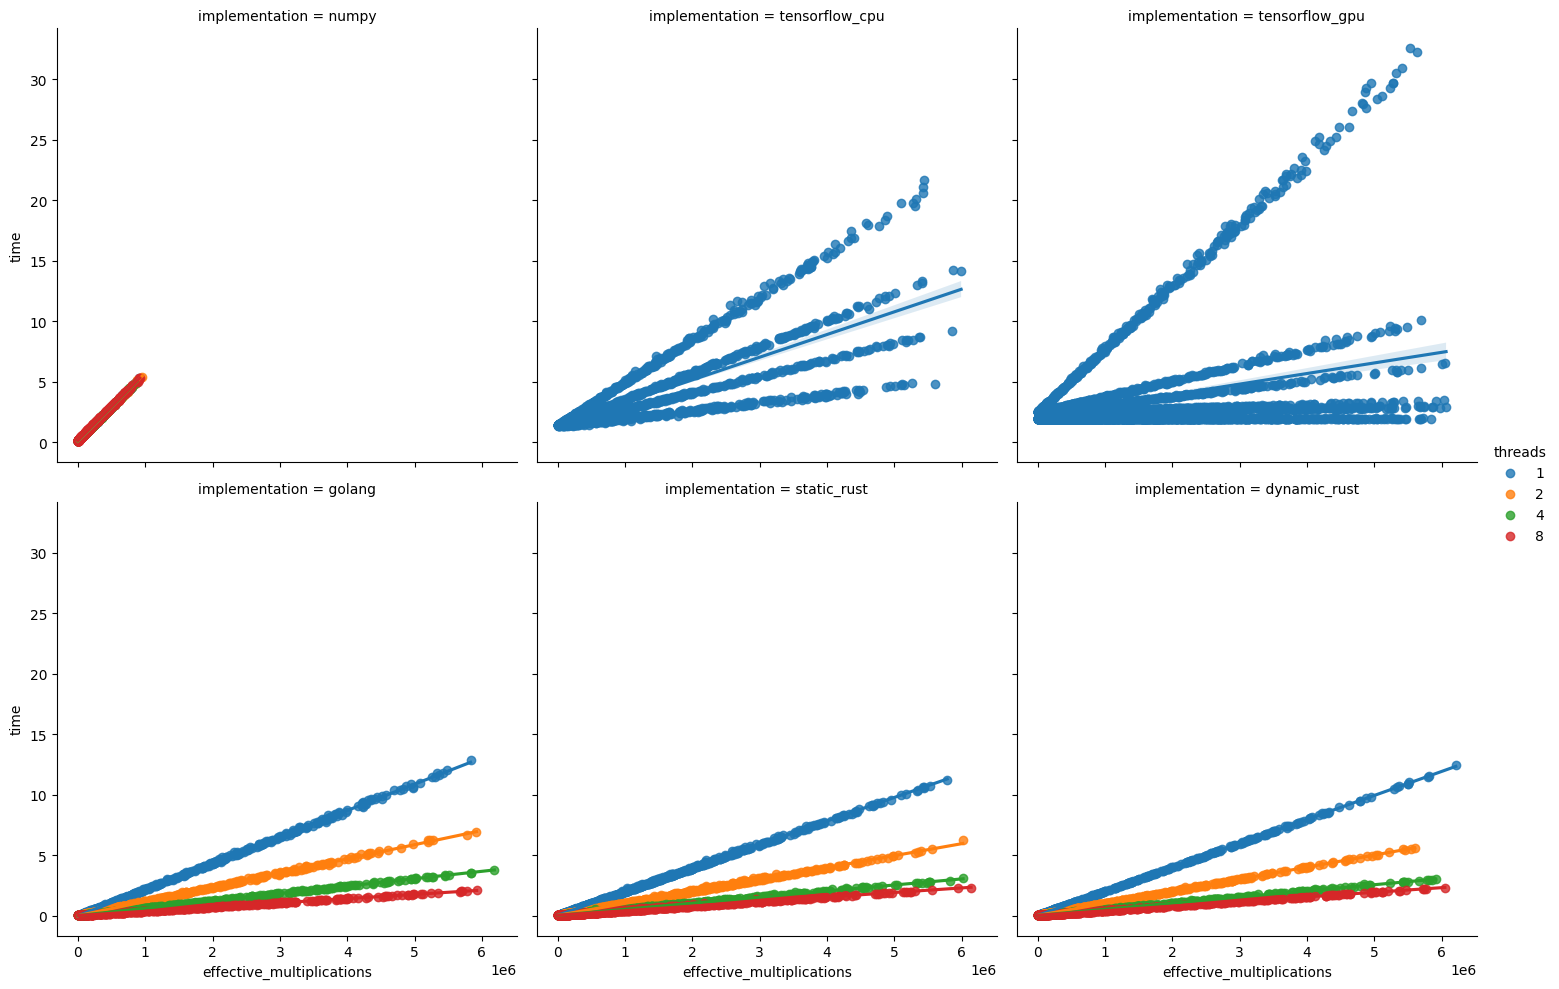

In [4]:
sns.lmplot(data=all_data, x="effective_multiplications", y="time", col="implementation", hue="threads", col_wrap=3)

We have a tiny amount of numpy data in comparison to other implementations. This is due to the immense slope of the data - numpy takes a very long time to run this experiment! We limited the trials and multiplications of numpy to only 1000, while other implementations were allowed to go to 2500. Because the numpy data is strongly linear this shouldn't be a problem.

We also note that the tensorflow implementations are strongly grouped/banded but are not coloured like the other data. This is due to tensorflow scaling off of batchsize, which  we will investigate below instead.

At a glance, it appears all data is strongly linear (somewhat expected) and increasing the number of threads results in lower times/better scaling (also expected!).

## Tensorflow Data - A Quick Look

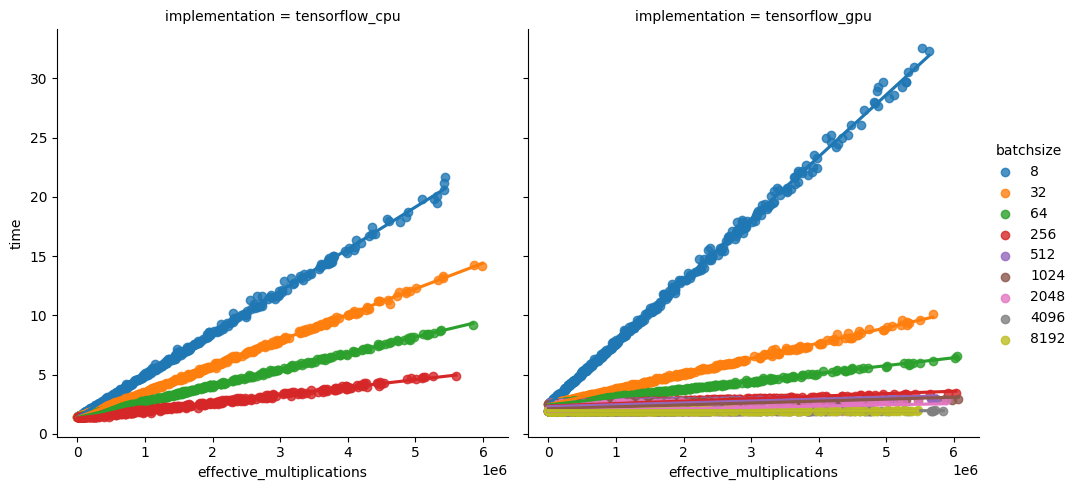

In [5]:
target_data = all_data.loc[(all_data["implementation"] == "tensorflow_cpu") | (all_data["implementation"] == "tensorflow_gpu")]

sns.lmplot(data=target_data, x="effective_multiplications", y="time", col="implementation", hue="batchsize")

Looking only at tensorflow data and coloring by batchsize now, we see the banding is perfectly explained by batchsize. Once more, as expected, we see increasing batchsizes results in better performance.

Something that is hard to spot is a small data anomaly in the tensorflow data. Let's take a closer look at the small time region:

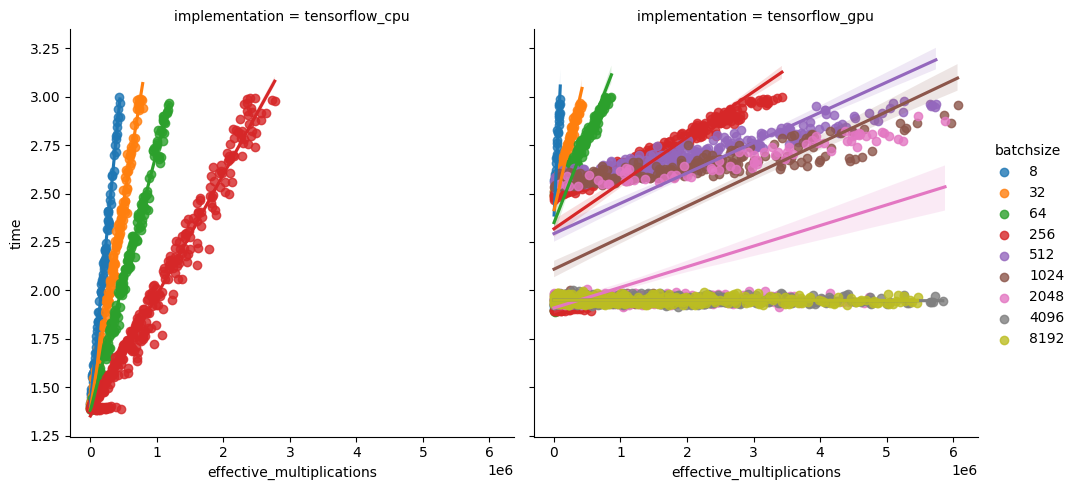

In [6]:
target_data = all_data.loc[(all_data["implementation"] == "tensorflow_cpu") | (all_data["implementation"] == "tensorflow_gpu")]
target_data = target_data.loc[target_data["time"]<3.0]

sns.lmplot(data=target_data, x="effective_multiplications", y="time", col="implementation", hue="batchsize")

There is some definite clustering of data at this small scale! We note that tensorflow has a large start up time compared to other implementations (hence the large y intercept - a couple of seconds for even tiny effective multiplications). There are some data instances that have a significantly shorter start up time. After re-inspecting the implementation for tensorflow, it appears that the number of trials was integer divided by the batchsize. This means if the number of trials is less than the batchsize, the tensorflow implementation would start up, do nothing, then quit again! To remove the effect of this bug we simply have to filter our dataframe for `trials<batchsize`.

In [11]:
condition = ((all_data["implementation"] == "tensorflow_cpu") | (all_data["implementation"] == "tensorflow_gpu")) & (all_data["trials"] < all_data["batchsize"])
display(all_data.loc[condition].head(10))
all_data = all_data.drop(all_data.loc[condition].index)

,trials,multiplications,threads,time,implementation,batchsize,effective_multiplications
1614,237,1117,1,1.400095,tensorflow_cpu,256,264729
1616,148,2151,1,1.403360,tensorflow_cpu,256,318348
1623,14,2005,1,1.400098,tensorflow_cpu,256,28070
1626,19,1094,1,1.386553,tensorflow_cpu,64,20786
1650,51,251,1,1.398285,tensorflow_cpu,64,12801
1691,3,409,1,1.396750,tensorflow_cpu,32,1227
1692,151,1022,1,1.383952,tensorflow_cpu,256,154322
1807,208,1109,1,1.388259,tensorflow_cpu,256,230672
1845,121,409,1,1.392324,tensorflow_cpu,256,49489
1860,128,96,1,1.390567,tensorflow_cpu,256,12288


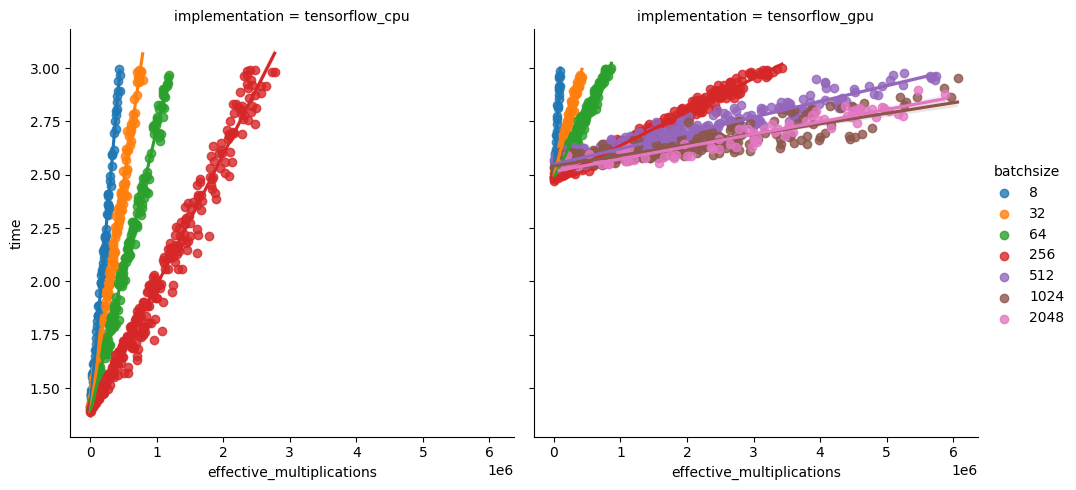

In [12]:
target_data = all_data.loc[(all_data["implementation"] == "tensorflow_cpu") | (all_data["implementation"] == "tensorflow_gpu")]
target_data = target_data.loc[target_data["time"]<3.0]

sns.lmplot(data=target_data, x="effective_multiplications", y="time", col="implementation", hue="batchsize")

Much better!

And finally we can inspect the other implementations closely:

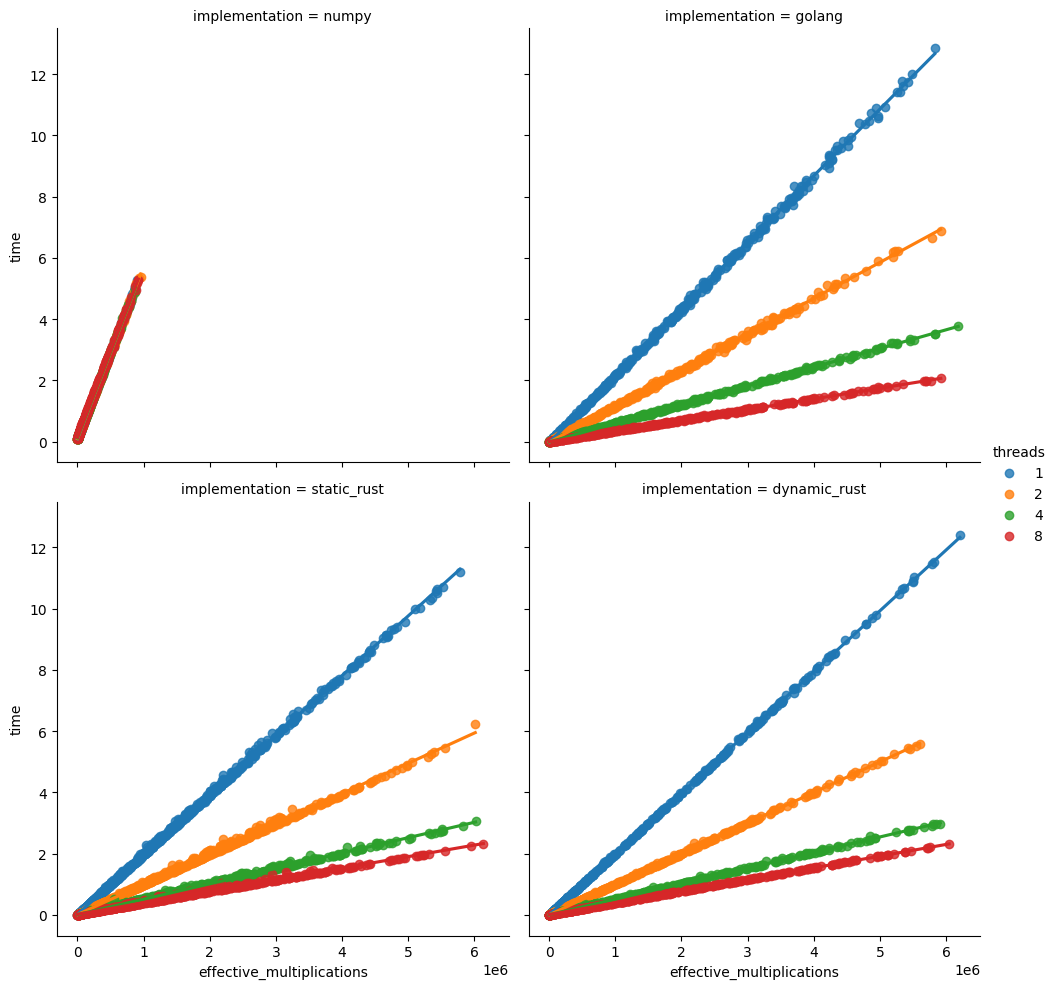

In [13]:
target_data = all_data.copy()
target_data = target_data.drop(target_data[target_data["implementation"] == "tensorflow_cpu"].index)
target_data = target_data.drop(target_data[target_data["implementation"] == "tensorflow_gpu"].index)

sns.lmplot(data=target_data, x="effective_multiplications", y="time", col="implementation", hue="threads", col_wrap=2)

# All Data By Implementation

Let's now have a look at each implementation based separated by threads/batchsize. Since we can see this data is very linear, let's try plotting a linear fit against each instance:

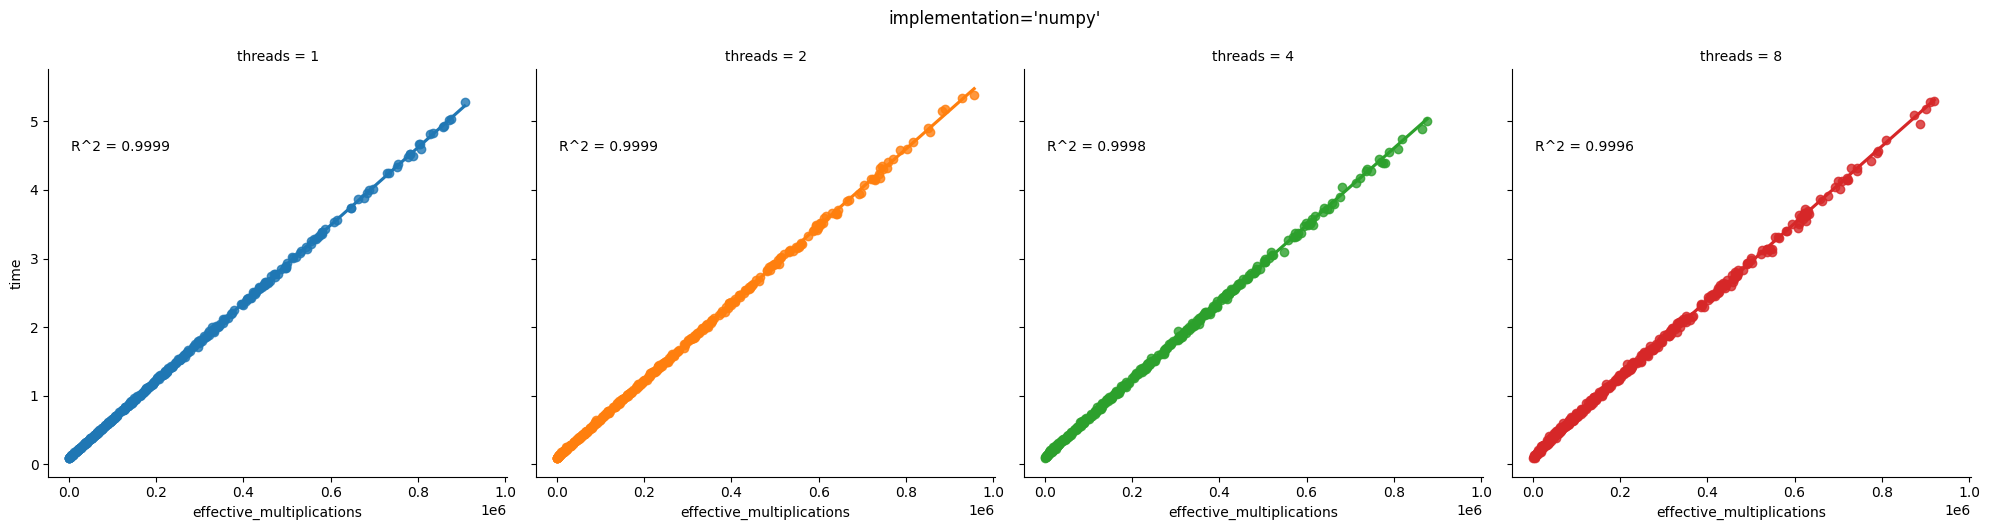

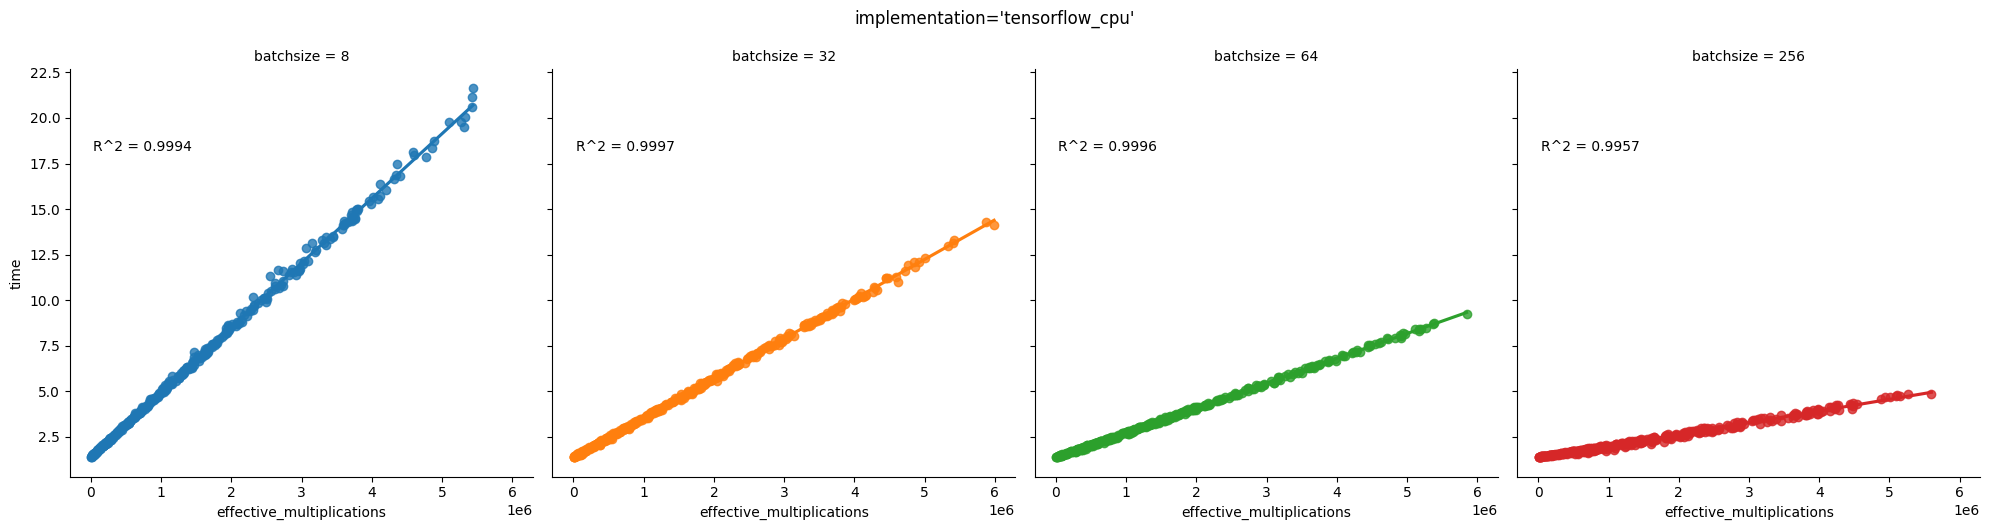

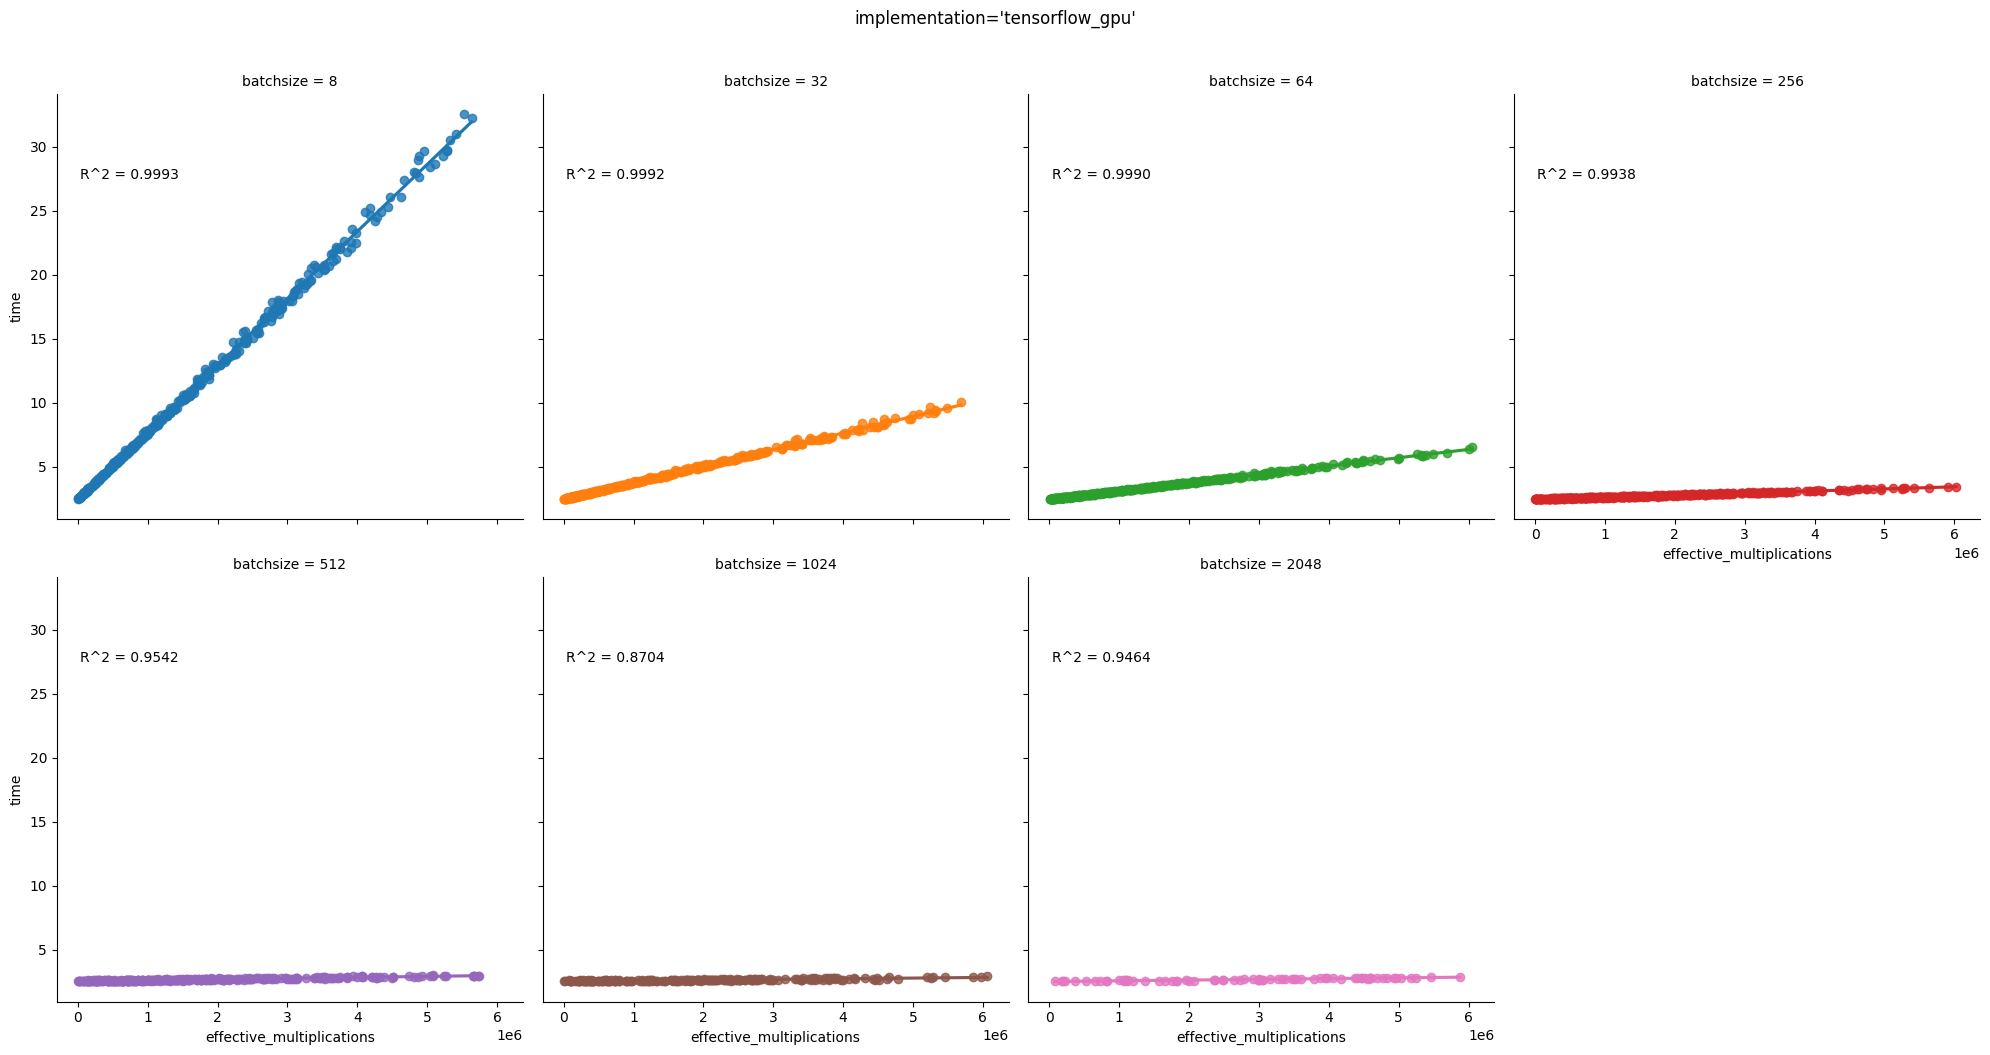

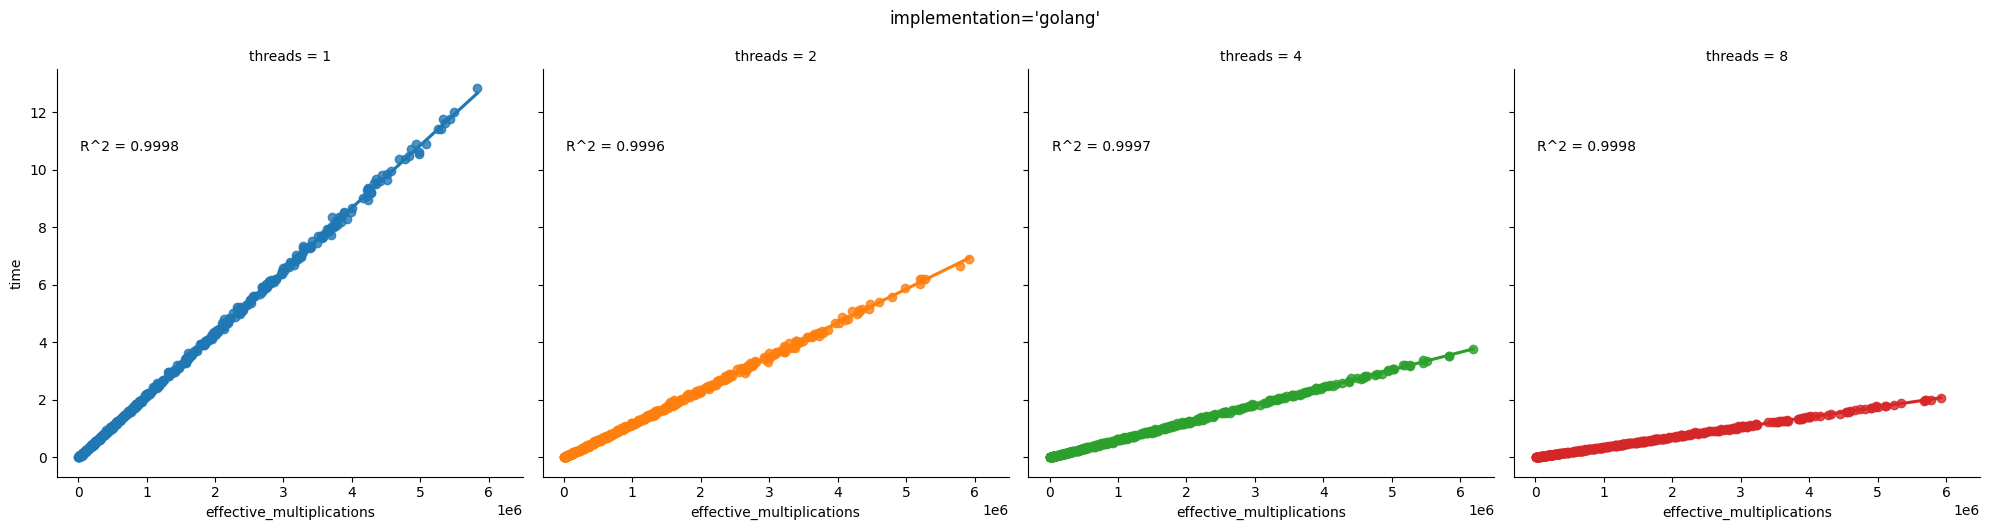

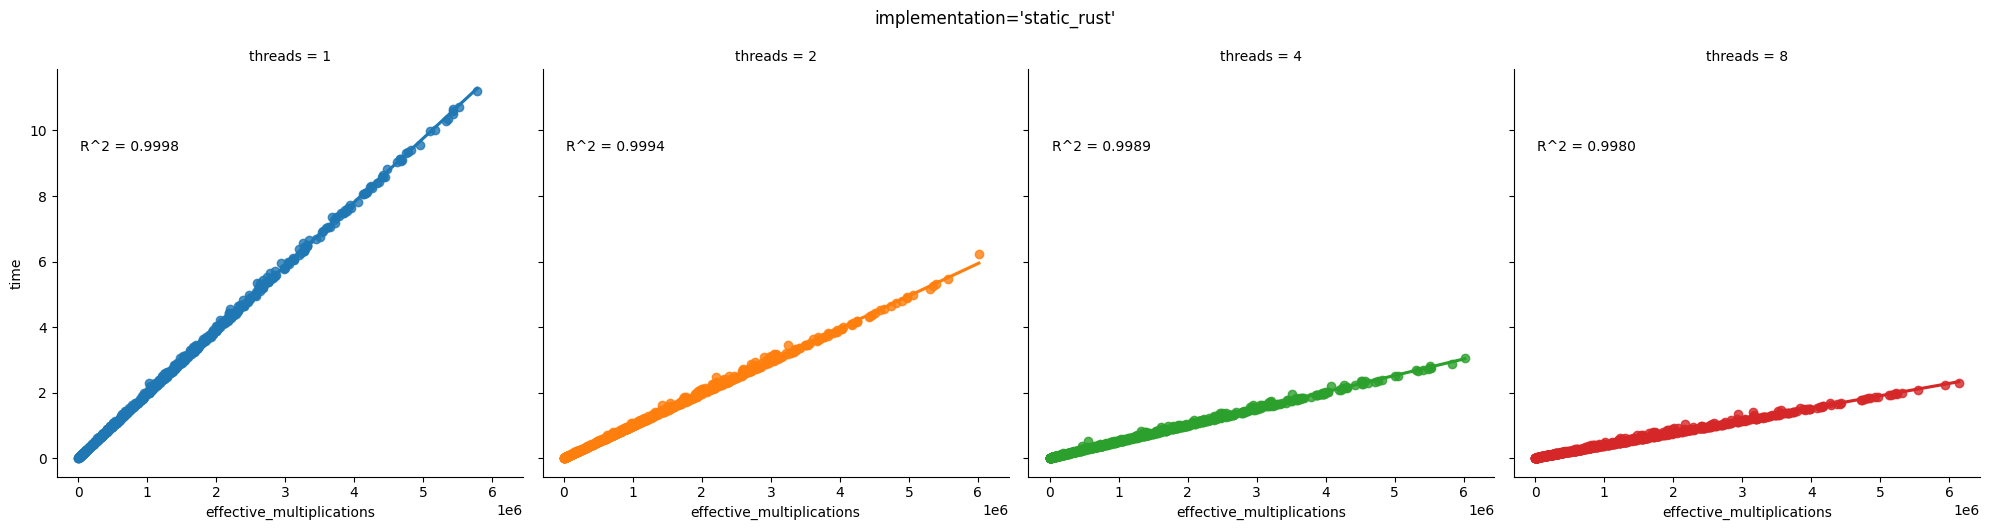

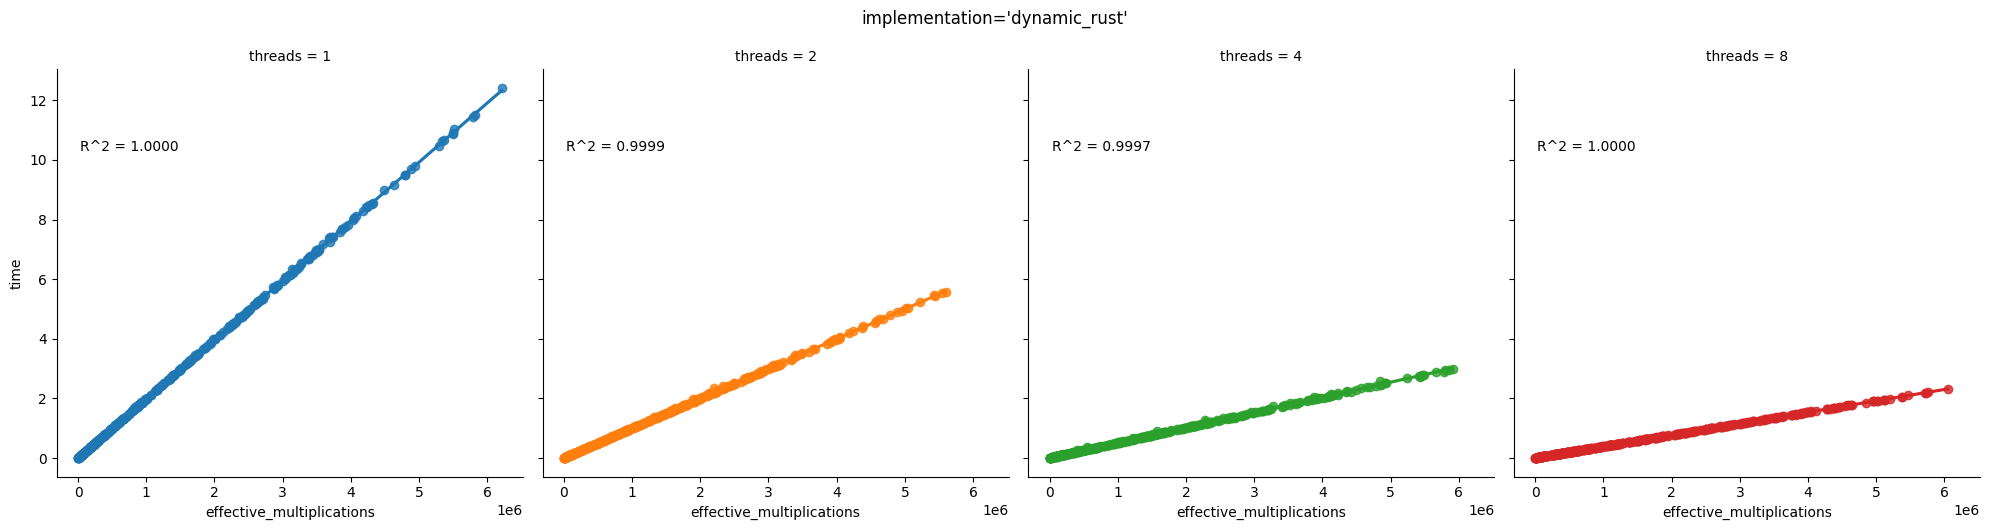

In [14]:
target_data = all_data.copy()

def annotate(data, **kws):
    """
    Utility method to apply R^2 to graphs.
    Taken from: https://stackoverflow.com/a/66325227
    """
    r, _ = scipy.stats.pearsonr(data['effective_multiplications'], data['time'])
    ax = plt.gca()
    ax.text(.05, .8, f"R^2 = {r:.4f}",
            transform=ax.transAxes)


for implementation in target_data.implementation.unique():
    col = "threads" if not implementation.startswith("tensorflow") else "batchsize"
    curr_plot = sns.lmplot(data=target_data.loc[target_data["implementation"]==implementation], x="effective_multiplications", y="time", col=col, hue=col, col_wrap=4)
    curr_plot.map_dataframe(annotate)
    curr_plot.fig.suptitle(f"{implementation=}", y=1.05)

As expected, all of our data is EXTREMELY linear - R^2>0.99 linear! This makes our lives very easy, as comparing implementations will effectively come down to analyzing slope and intercept!

# Data by Trial and Multiplications

It is possible that some implementations suffer more from trials compared to multiplications (or vice versa). For example, it is possible an implementation scales quadratically with multiplications but inverse quadratically (square-root-ly?) with trials, explaining the linear relationship we see above. We will investigate this now.

I encourage you to play around with the `showfliers` argument to `sns.boxenplot`. This shows/hides the outliers in the timing data - some of which can be relatively significant! The tensorflow outliers have been hidden in this upload to demonstrate the spread of the majority of the data, but feel free to investigate for yourself. Also consider removing the `sharex` argument to `plt.subplots` to avoid tensorflow outliers dominating both plots.

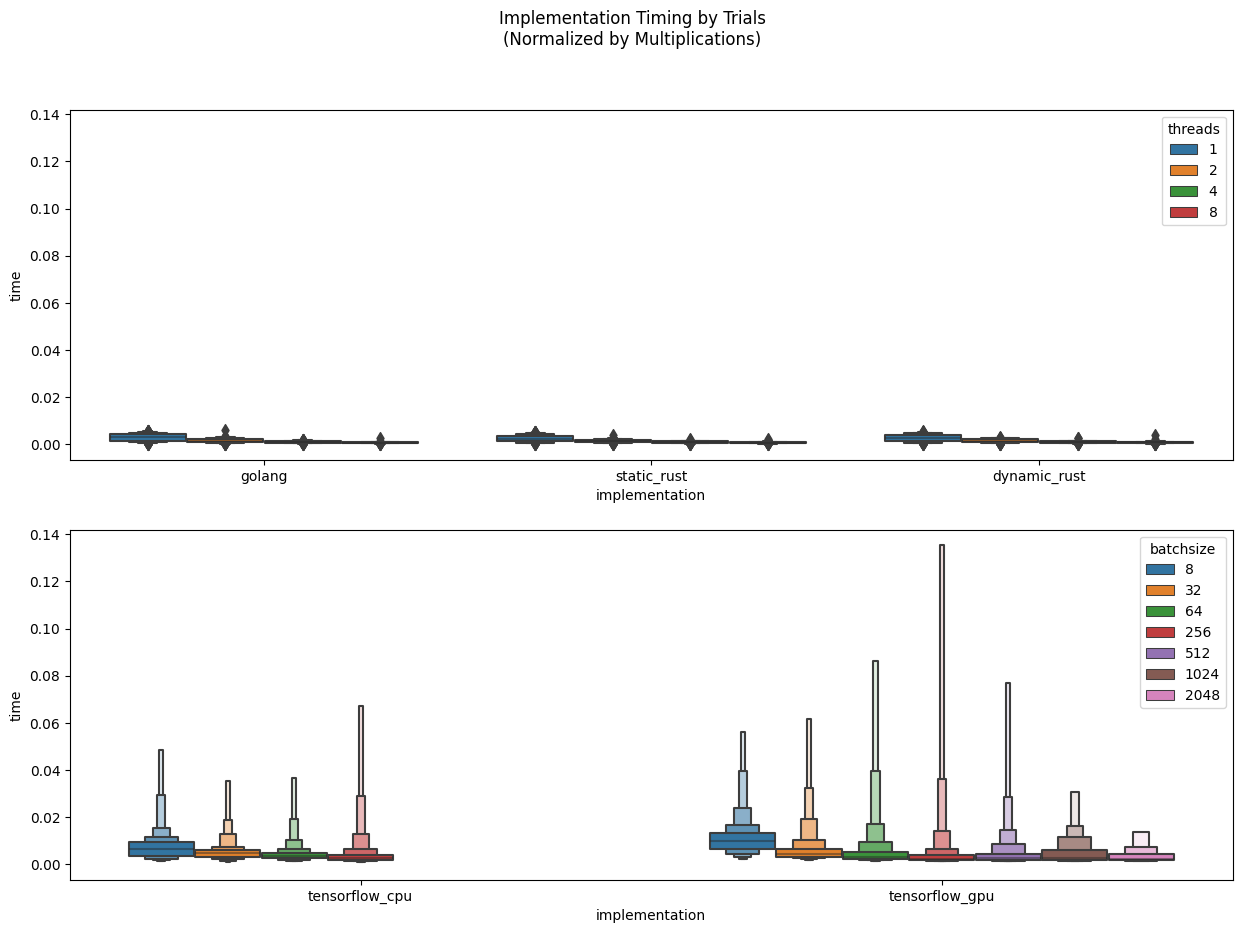

In [15]:
target_data = all_data.copy()
target_data["time"] /= target_data["multiplications"]
target_data = target_data.drop(target_data[target_data["implementation"] == "numpy"].index)

fig, axes = plt.subplots(2,1,figsize=(15, 10),sharey=True)
fig.suptitle("Implementation Timing by Trials\n(Normalized by Multiplications)")

compiled_impl_data = target_data
compiled_impl_data = compiled_impl_data.drop(compiled_impl_data[compiled_impl_data["implementation"].str.startswith("tensorflow")].index)
plot1 = sns.boxenplot(data=compiled_impl_data, y="time", x="implementation", hue="threads", showfliers=True, ax=axes[0])

tensorflow_data = target_data
tensorflow_data = tensorflow_data.loc[tensorflow_data["implementation"].str.startswith("tensorflow")]
plot2 = sns.boxenplot(data=tensorflow_data, y="time", x="implementation", hue="batchsize", showfliers=False, ax=axes[1])


plt.show()

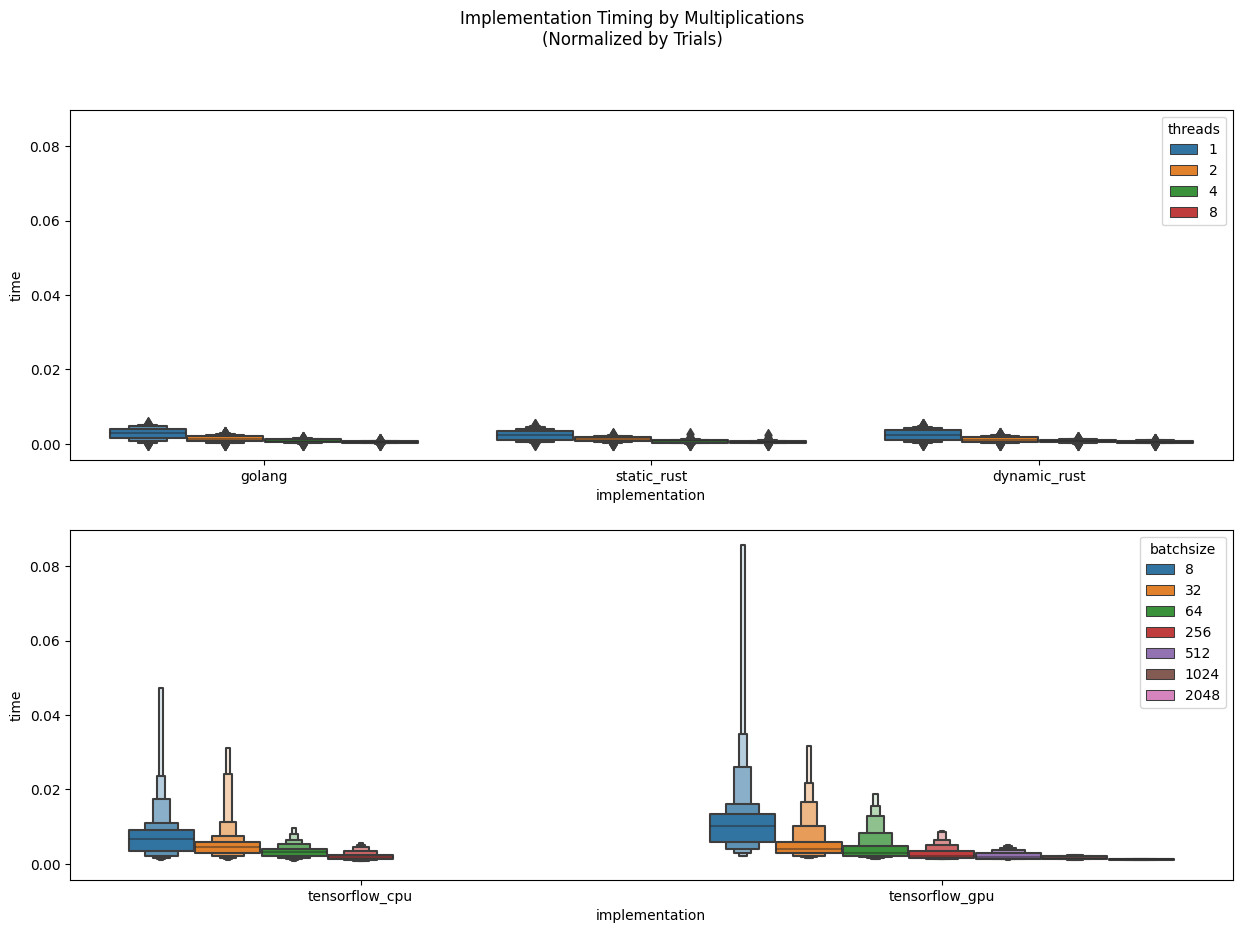

In [16]:
target_data = all_data.copy()
target_data["time"] /= target_data["trials"]
target_data = target_data.drop(target_data[target_data["implementation"] == "numpy"].index)

fig, axes = plt.subplots(2,1,figsize=(15, 10),sharey=True) 
fig.suptitle("Implementation Timing by Multiplications\n(Normalized by Trials)")

compiled_impl_data = target_data
compiled_impl_data = compiled_impl_data.drop(compiled_impl_data[compiled_impl_data["implementation"].str.startswith("tensorflow")].index)
plot1 = sns.boxenplot(data=compiled_impl_data, y="time", x="implementation", hue="threads", showfliers=True, ax=axes[0])

tensorflow_data = target_data
tensorflow_data = tensorflow_data.loc[tensorflow_data["implementation"].str.startswith("tensorflow")]
plot2 = sns.boxenplot(data=tensorflow_data, y="time", x="implementation", hue="batchsize", showfliers=False, ax=axes[1])


plt.show()

It appears that tensorflow struggles a lot more with trials compared to multiplications - especially when it comes to increased batchsize! I would imagine this is because in the tensorflow implementation creating a new batch was always CPU bound. If the CPU happened to be relatively busy when a new batch was requested it may take some time to generate before being processed. This is why the spread in time for tensorflow in the trials case is so large, and only increasing with larger batchsizes. Notice how this effect is only exacerbated by moving the multiplications to the GPU - the CPU bound batch generation can now significantly slow down the process! Try showing the outlier for the tensorflow data to show just how significant this effect can be.

The compiled languages don't seem to suffer this same fate - even with outliers shown. I would attribute this to each thread being CPU bound already and having to generate a single vector at a time for multiplication. The batch effect can't come into play! I would also imagine the compiled languages may take advantage of CPU designs that allow for speculative execution i.e. the next vector may already be in the process of generation while the previous vector is being processed. This may help amortise any random CPU fluctuations.

Also not we have eschewed the numpy implementation here, as it would dominate the graphs and is already shown to be relatively low performance.

# Saving the Data

In [17]:
all_data.to_csv("AggregatedRandomClean.csv")